# Compute metrics for different runs and plot them
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
pip install tqdm
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash
from build_data import build_hurricane_data
from build_model import build_shash_model, build_bnn_model, build_mcdrop_model
import model_diagnostics
from silence_tensorflow import silence_tensorflow
import prediction
from sklearn.neighbors import KernelDensity
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

silence_tensorflow()
dpiFig = 400

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "19 January 2022"

EXP_NAME_LIST = (
                 "intensity4_EPCP72",
                 "intensity5_EPCP72",    
                 # "intensity14_EPCP72",# mcdrop 75% [100,50]  
                 # "intensity16_EPCP72",  # mcdrop 75% [300,200] 
                 "intensity19_EPCP72",  # mcdrop 95% [300,200]     
                 # "intensity17_EPCP72",
                 # "intensity18_EPCP72",    
                )
APPEND_NAME = '_mcdropComparison'

# EXP_NAME_LIST = (
#                  "intensity8_AL96",
#                  "intensity9_AL96",
#                  "intensity10_EPCP96",
#                  "intensity11_EPCP96",
#                  "intensity0_AL72",
#                  "intensity1_AL72",
#                  "intensity4_EPCP72",
#                  "intensity5_EPCP72",
#                  "intensity12_AL48",
#                  "intensity13_AL48",    
#                  "intensity2_EPCP48",
#                  "intensity3_EPCP48",
#                 )
# APPEND_NAME = ''


# EXP_NAME_LIST = (
#                  "intensity204_AL72",
#                  "intensity205_AL72",
#                  "intensity202_EPCP72",
#                  "intensity203_EPCP72",            
#                  "intensity206_AL48",
#                  "intensity207_AL48",
#                  "intensity200_EPCP48",
#                  "intensity201_EPCP48",    
#                 )
# APPEND_NAME = '_clusterExtrapolation'
# APPEND_NAME = '_clusterExtrapolationAllClusters'



OVERWRITE_METRICS = False
DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "model_metrics/"
FIGURE_PATH = "figures/summary_plots/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Define get_metrics()

In [4]:
def get_metrics():
    tf.random.set_seed(network_seed)
    shash_incs = np.arange(-160,161,1)

    if settings["uncertainty_type"] == "bnn" or settings["uncertainty_type"] == "mcdrop":       
        # loop through runs for bnn calculation    
        runs = 5_000
        bins_plot = np.linspace(np.min(shash_incs), np.max(shash_incs), 1000)
        bnn_cpd = np.zeros((np.shape(x_eval)[0],runs))
        bnn_mode = np.zeros((np.shape(x_eval)[0],))

        for i in tqdm(range(0,runs)):
            if settings["uncertainty_type"] == "bnn":
                bnn_cpd[:,i] = np.reshape(model_bnn.predict(x_eval),np.shape(bnn_cpd)[0])
            elif settings["uncertainty_type"] == "mcdrop":
                # np.stack([model_mcdrop(x_eval,training=True) for sample in range (5_000)])
                bnn_cpd[:,i] = np.reshape(model_mcdrop(x_eval,training=True),np.shape(bnn_cpd)[0])                
            else:
                raise NotImplementedError
                
        bnn_mean = np.mean(bnn_cpd,axis=1)
        bnn_median = np.median(bnn_cpd,axis=1)

        for j in tqdm(range(0,np.shape(bnn_mode)[0])):
            kde = KernelDensity(kernel="gaussian", bandwidth=4.).fit(bnn_cpd[j,:].reshape(-1,1))
            log_dens = kde.score_samples(bins_plot.reshape(-1,1))
            i = np.argmax(log_dens)
            bnn_mode[j] = bins_plot[i]

        mean_error, median_error, mode_error = model_diagnostics.compute_errors(onehot_eval, bnn_mean, bnn_median, bnn_mode)         
        bins, hist_bnn, pit_D, EDp_bnn = model_diagnostics.compute_pit('bnn',onehot_eval, bnn_cpd)
        iqr_capture = model_diagnostics.compute_interquartile_capture('bnn',onehot_eval, bnn_cpd)
        iqr_error_spearman, iqr_error_pearson = model_diagnostics.compute_iqr_error_corr('bnn',
                                                                                          onehot_val=onehot_eval, 
                                                                                          bnn_cpd=bnn_cpd, 
                                                                                          pred_median=bnn_median,
                                                                                         )
        
    else:        
        shash_cpd = np.zeros((np.shape(x_eval)[0],len(shash_incs)))
        shash_mean = np.zeros((np.shape(x_eval)[0],))
        shash_med = np.zeros((np.shape(x_eval)[0],))
        shash_mode = np.zeros((np.shape(x_eval)[0],))

        # loop through samples for shash calculation and get PDF for each sample
        for j in tqdm(range(0,np.shape(shash_cpd)[0])):
            mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_eval[np.newaxis,j], model_shash )
            shash_cpd[j,:] = shash.prob(shash_incs, mu_pred, sigma_pred, gamma_pred, tau_pred)    
            shash_mean[j]  = shash.mean(mu_pred,sigma_pred,gamma_pred,tau_pred)#np.sum(shash_cpd[j,:]*shash_incs)
            shash_med[j]   = shash.median(mu_pred,sigma_pred,gamma_pred,tau_pred)

            i = np.argmax(shash_cpd[j,:])
            shash_mode[j]  = shash_incs[i]

        mean_error, median_error, mode_error = model_diagnostics.compute_errors(onehot_eval, shash_mean, shash_med, shash_mode)    
        bins, hist_shash, pit_D, EDp_shash = model_diagnostics.compute_pit('shash',onehot_eval, x_val=x_eval,model_shash=model_shash)
        iqr_capture = model_diagnostics.compute_interquartile_capture('shash',onehot_eval, x_val=x_eval,model_shash=model_shash)
        iqr_error_spearman, iqr_error_pearson = model_diagnostics.compute_iqr_error_corr('shash',
                                                                                                onehot_val=onehot_eval,
                                                                                                pred_median=shash_med,
                                                                                                x_val=x_eval,
                                                                                                model_shash=model_shash,
                                                                                               )

    # by definition Consensus is a correction of zero
    cons_error = np.mean(np.abs(0.0 - onehot_eval[:,0]))
        
    return mean_error,median_error,mode_error,pit_D,iqr_capture,cons_error,iqr_error_spearman,iqr_error_pearson


## Evaluate the models

In [5]:
raise ValueError('do not compute metrics yet')

ValueError: do not compute metrics yet

In [ ]:
# # y_predict = np.stack([model_mcdrop(x_eval,training=True) for sample in range (5_000)])
# # np.shape(y_predict)

# isample = 20
# plt.hist(y_predict[:,isample,0])
# plt.axvline(x=df_eval['OBDV'].to_numpy()[isample],linestyle='--')
# plt.show()

In [ ]:
import imp
imp.reload(model_diagnostics)

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    RNG_SEED_LIST = np.copy(settings['rng_seed'])

    for rng_seed in RNG_SEED_LIST:
        settings['rng_seed'] = rng_seed
        NETWORK_SEED_LIST = [settings["rng_seed"]]
        network_seed = NETWORK_SEED_LIST[0]
        tf.random.set_seed(network_seed)  # This sets the global random seed.    

        #----------------------------------------------------------------------------------------------------
        # get the data
        (
            x_train,
            onehot_train,
            x_val,
            onehot_val,
            x_eval,
            onehot_eval,    
            data_summary,
            df_val,
            df_eval,
        ) = build_hurricane_data(DATA_PATH, settings, verbose=0)

        #----------------------------------------------------------------------------------------------------
        # get the model
        if settings["uncertainty_type"] == "bnn":       
            model_name_bnn = (
                exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )
            model_bnn = build_bnn_model(
                x_train,
                onehot_train,
                hiddens=settings["hiddens"],
                output_shape=onehot_train.shape[1],
                ridge_penalty=settings["ridge_param"],
                act_fun=settings["act_fun"],
            )
            try:
                model_bnn.load_weights(MODEL_PATH + model_name_bnn + "_weights.h5")
            except:
                print('tf model does not exist. skipping...')
                continue
            model_name = model_name_bnn
            
        elif settings["uncertainty_type"] == "mcdrop":       
            model_name_mcdrop = (
                exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )
            model_mcdrop = build_mcdrop_model(
                x_train,
                onehot_train,
                dropout_rate=settings["dropout_rate"],                
                hiddens=settings["hiddens"],
                output_shape=onehot_train.shape[1],
                ridge_penalty=settings["ridge_param"],
                act_fun=settings["act_fun"],
            )
            try:
                model_mcdrop.load_weights(MODEL_PATH + model_name_mcdrop + "_weights.h5")
            except:
                print('tf model does not exist. skipping...')
                continue
            model_name = model_name_mcdrop

        elif settings["uncertainty_type"][:5] == "shash": 
            model_name_shash = (
                exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )
            model_shash = build_shash_model(
                x_train,
                onehot_train,
                hiddens=settings["hiddens"],
                output_shape=onehot_train.shape[1],
                ridge_penalty=settings["ridge_param"],
                act_fun=settings["act_fun"],
            )
            try:
                model_shash.load_weights(MODEL_PATH + model_name_shash + "_weights.h5")
            except:
                print('tf model does not exist. skipping...')
                continue
            model_name = model_name_shash

        #----------------------------------------------------------------------------------------------------
        # check if the metric filename exists already
        if(APPEND_NAME == "_clusterExtrapolationAllClusters"):
            metric_filename = METRIC_PATH + model_name + '_metrics_allClusters.pkl'
        else:
            metric_filename = METRIC_PATH + model_name + '_metrics.pkl'  
            
        if (os.path.exists(metric_filename) and OVERWRITE_METRICS==False):
            # print(metric_filename + ' exists. Skipping...')
            continue
            
        # get metrics and put into a dictionary
        pprint.pprint(model_name)
        
        # if running out of cluster comparison, grab only the cluster that was not seen during training
        if(settings["train_condition"]=='cluster' and APPEND_NAME != "_clusterExtrapolationAllClusters"):
            print('grabbing out of sample ' + 'CLUSTER')
            i_index = np.where(data_summary["cluster_eval"] == data_summary["cluster_out"])[0]
            x_eval = x_eval[i_index,:]
            onehot_eval = onehot_eval[i_index,:]
            df_eval.iloc[i_index]       
        
        # compute the metrics
        mean_error, median_error, mode_error, pit_D, iqr_capture, cons_error, iqr_error_spearman,iqr_error_pearson = get_metrics()        
        d = {'uncertainty_type': settings["uncertainty_type"],
             'network_seed': network_seed,
             'rng_seed': settings['rng_seed'],
             'exp_name': exp_name,
             'mean_error': mean_error,
             'median_error': median_error,
             'mode_error': mode_error,
             'cons_error': cons_error,
             'pit_d': pit_D,
             'iqr_capture': iqr_capture,
             'iqr_error_spearman': iqr_error_spearman[0],
             'iqr_error_pearson': iqr_error_pearson[0],             
             'iqr_error_spearman_p': iqr_error_spearman[1],
             'iqr_error_pearson_p': iqr_error_pearson[1],             
        }
        pprint.pprint(d, width=80)  
        df = pd.DataFrame(data=d, index=[0])
        df.to_pickle(metric_filename)

In [ ]:
raise ValueError('do not plot yet')

In [6]:
df_metrics = pd.DataFrame()

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)
    RNG_SEED_LIST = np.copy(settings['rng_seed'])
    
    for rng_seed in RNG_SEED_LIST:
        settings['rng_seed'] = rng_seed
        NETWORK_SEED_LIST = [settings["rng_seed"]]
        network_seed = NETWORK_SEED_LIST[0]
    
        model_name = (
                exp_name + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        
        # load the metric filename
        if(APPEND_NAME == "_clusterExtrapolationAllClusters"):
            metric_filename = METRIC_PATH + model_name + '_metrics_allClusters.pkl'
        else:
            metric_filename = METRIC_PATH + model_name + '_metrics.pkl'  
        if os.path.exists(metric_filename)==False:
            print(metric_filename + ' DOES NOT exist. Skipping...')
            continue
    
        # pprint.pprint(model_name)
        df = pd.read_pickle(metric_filename)
        df['basin_lead'] = exp_name[exp_name.rfind('_')+1:]
        df['mean_error_reduction'] = df['cons_error']-df['mean_error']
        df['median_error_reduction'] = df['cons_error']-df['median_error']        
        df['mode_error_reduction'] = df['cons_error']-df['mode_error']        
        df_metrics = pd.concat([df_metrics,df])
df_metrics

,uncertainty_type,network_seed,rng_seed,exp_name,mean_error,median_error,mode_error,cons_error,pit_d,iqr_capture,iqr_error_spearman,iqr_error_pearson,iqr_error_spearman_p,iqr_error_pearson_p,basin_lead,mean_error_reduction,median_error_reduction,mode_error_reduction
0,shash3,605,605,intensity4_EPCP72,13.359159,13.306617,13.359570,15.026367,0.015048,0.466797,0.386633,0.371825,1.058868e-19,3.120081e-18,EPCP72,1.667208,1.719751,1.666797
0,shash3,122,122,intensity4_EPCP72,13.165229,13.366956,14.829102,14.800196,0.016522,0.476562,0.353323,0.351593,1.685201e-16,2.415028e-16,EPCP72,1.634967,1.433240,-0.028906
0,shash3,786,786,intensity4_EPCP72,13.842988,13.757158,13.936719,15.453905,0.023596,0.408203,0.421174,0.390751,1.970041e-23,4.005984e-20,EPCP72,1.610917,1.696747,1.517186
0,shash3,311,311,intensity4_EPCP72,14.062344,14.058434,14.644727,15.702539,0.026070,0.417969,0.385062,0.385690,1.528651e-19,1.320298e-19,EPCP72,1.640195,1.644106,1.057813
0,shash3,888,888,intensity4_EPCP72,13.841968,13.729241,14.191016,15.117969,0.018750,0.505859,0.208683,0.242090,1.907811e-06,2.902642e-08,EPCP72,1.276000,1.388727,0.926953
0,shash3,999,999,intensity4_EPCP72,12.874287,12.837004,13.332031,14.423046,0.007754,0.496094,0.358636,0.351238,5.503993e-17,2.599802e-16,EPCP72,1.548759,1.586042,1.091015
0,shash3,578,578,intensity4_EPCP72,12.865113,12.906931,13.548047,14.828516,0.011449,0.464844,0.297970,0.300334,5.869752e-12,3.920282e-12,EPCP72,1.963403,1.921585,1.280469
0,shash3,331,331,intensity4_EPCP72,12.451141,12.616249,13.640039,14.701757,0.019876,0.455078,0.377844,0.366962,8.054041e-19,9.131301e-18,EPCP72,2.250616,2.085508,1.061718
0,shash3,908,908,intensity4_EPCP72,12.994962,13.010082,13.894922,14.737499,0.017574,0.468750,0.375405,0.387908,1.399115e-18,7.848394e-20,EPCP72,1.742537,1.727417,0.842577
0,shash3,444,444,intensity4_EPCP72,13.477514,13.604192,14.467578,15.319141,0.019232,0.476562,0.390041,0.409059,4.741876e-20,4.494443e-22,EPCP72,1.841627,1.714950,0.851563


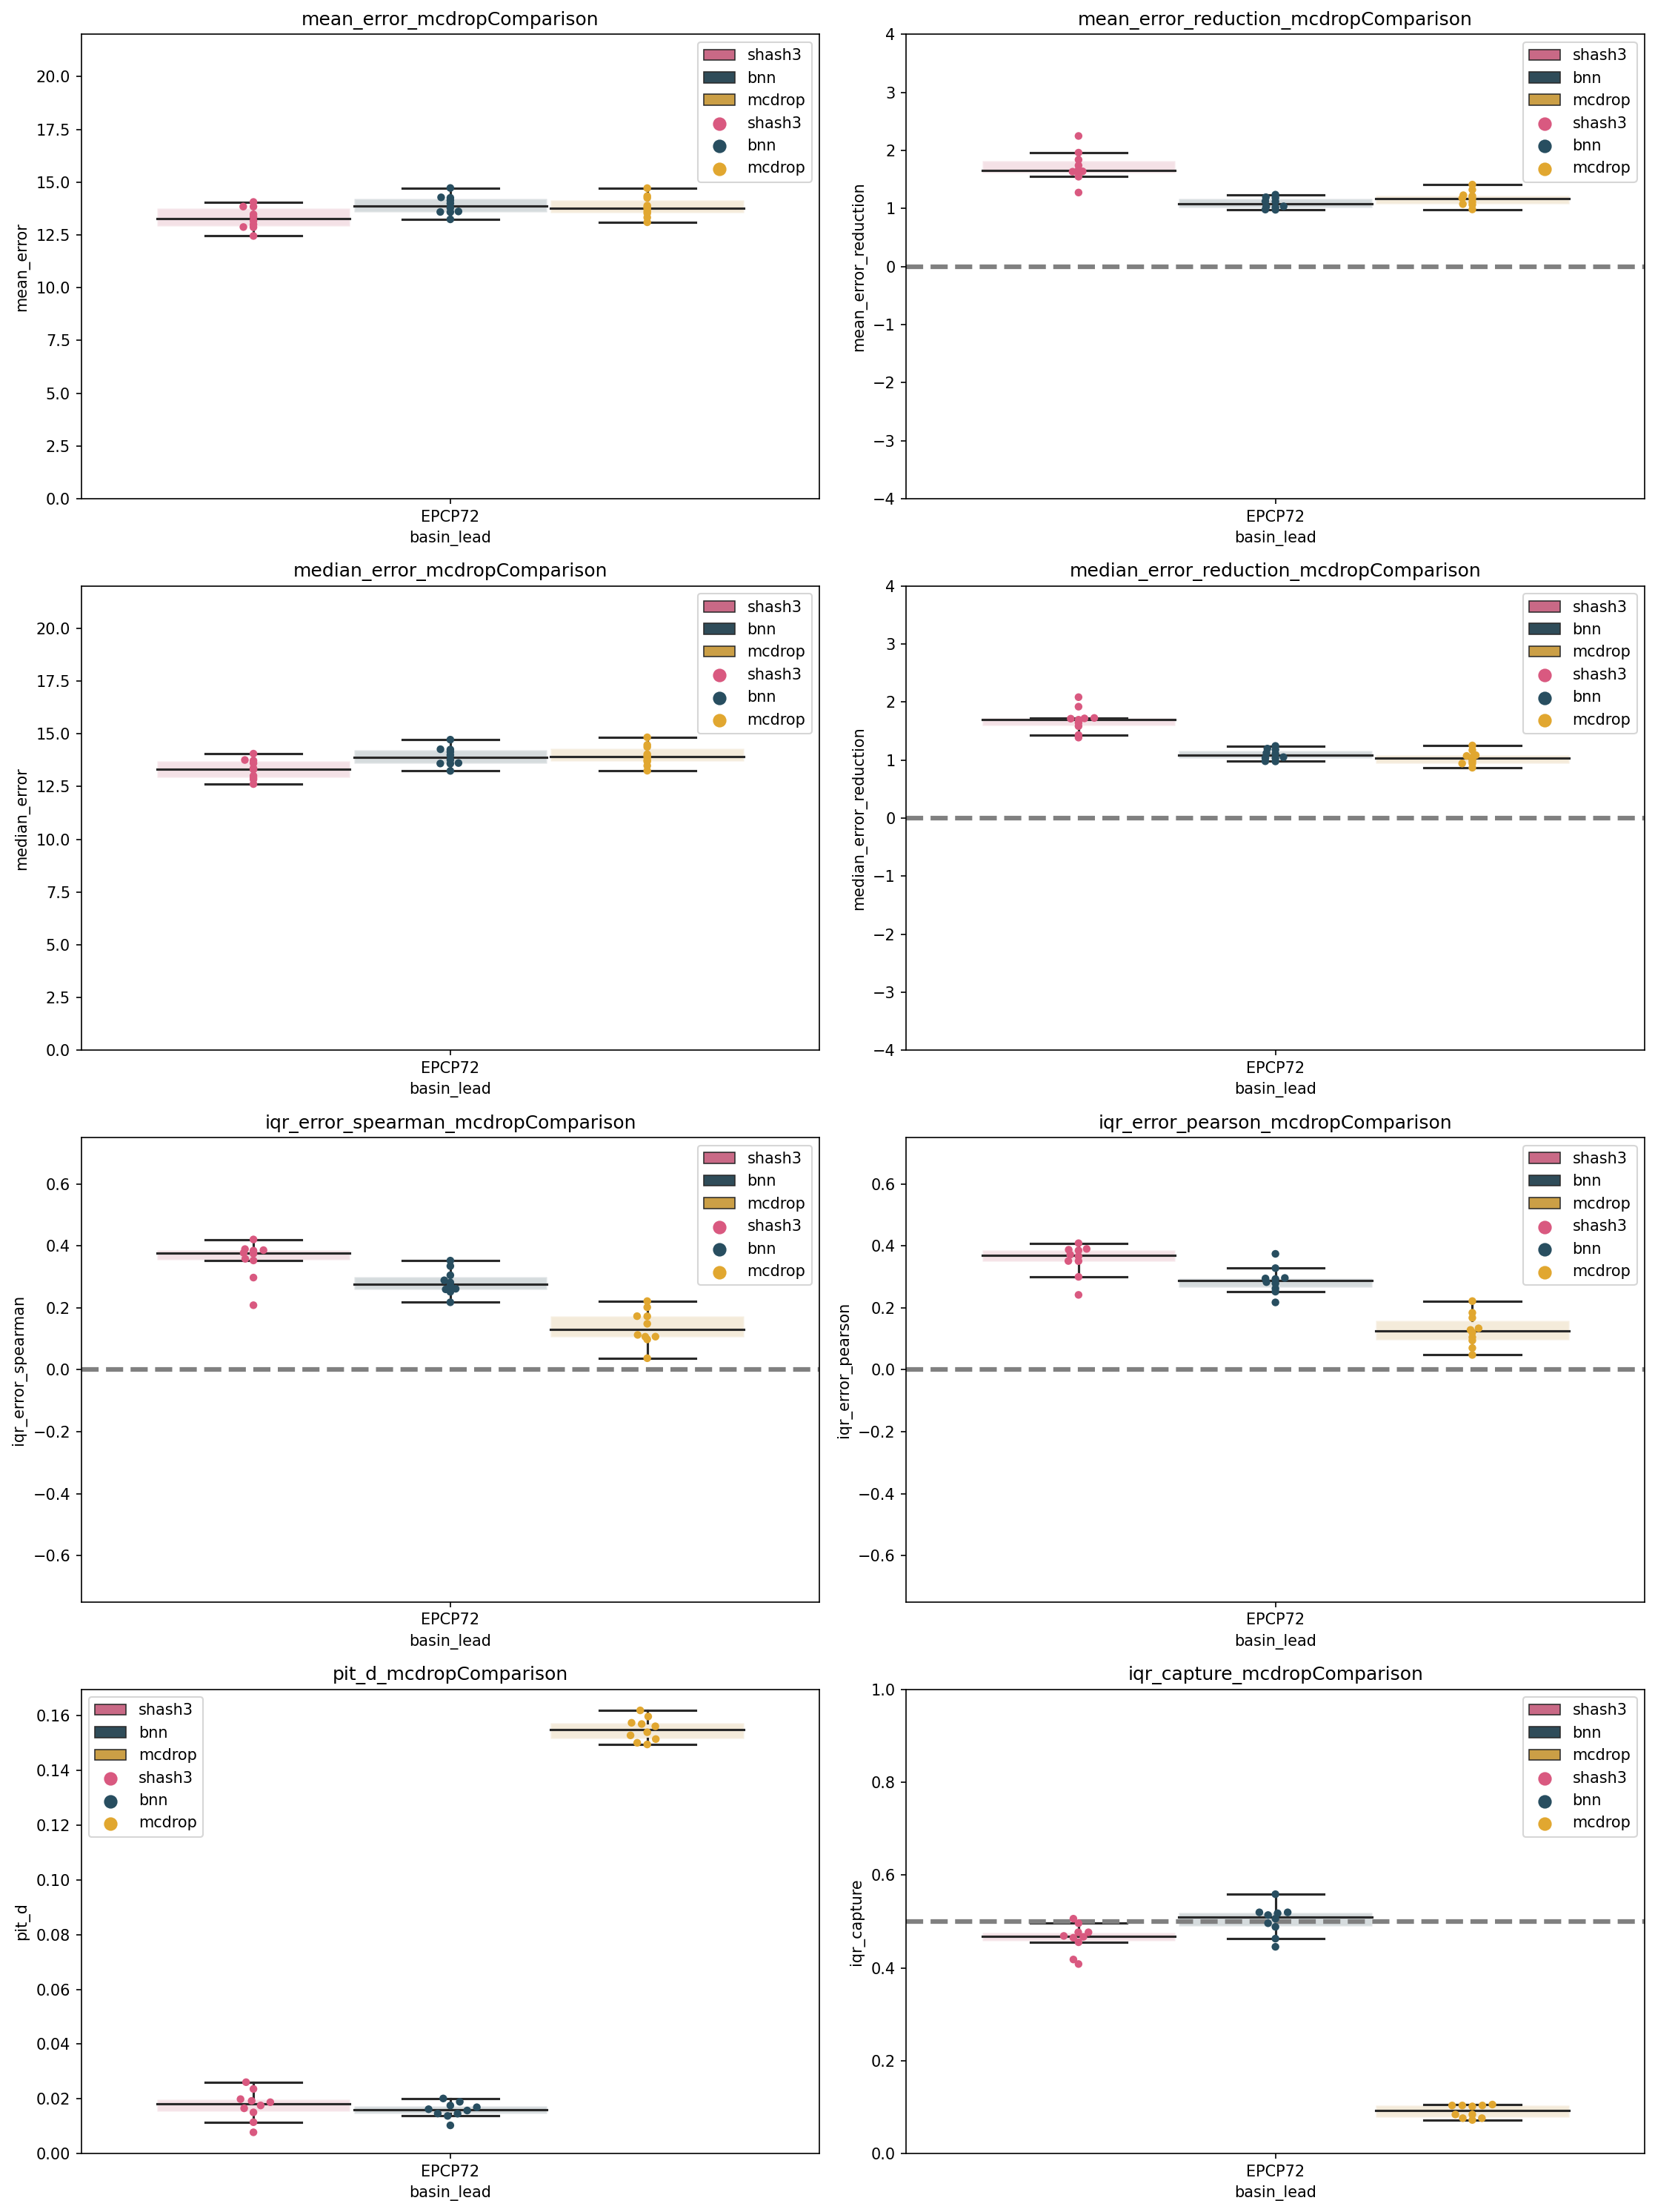

In [7]:
import seaborn as sns
f, axs = plt.subplots(4, 2, figsize=(15,20))
axs = axs.flatten()
colors = ('#D95980','#284E60','#E1A730','#284E60')

for imetric, metric in enumerate(('mean_error',
                                  'mean_error_reduction',
                                  'median_error',
                                  'median_error_reduction',                                  
                                  'iqr_error_spearman',
                                  'iqr_error_pearson',                                  
                                  # 'mode_error',
                                  # 'mode_error_reduction',                                  
                                  'pit_d',
                                  'iqr_capture')):
    ax = axs[imetric]
    g1 = sns.boxplot(x='basin_lead', 
                     y=metric, 
                     hue="uncertainty_type",
                     data=df_metrics,
                     palette=colors,
                     boxprops={'alpha':.2,
                               'edgecolor': 'white',
                              },
                     fliersize=0,
                     ax=ax)
    g2 = sns.swarmplot(x="basin_lead", 
                       y=metric, 
                       hue="uncertainty_type",
                       palette=colors,
                       data=df_metrics, 
                       dodge=True,
                       ax=ax)
    
    if(metric=='iqr_capture'):
        ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
        ax.set_ylim(0,1.0)
    if(metric=='pit_d'):
        ax.set_ylim(0,None)
    if(metric.find('reduction') > -1):
        ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
        ax.set_ylim(-4.,4.)
    if(metric.find('reduction') == -1 and metric.find('n_error') > -1):
        ax.set_ylim(0.,22.)
    if(metric.find('iqr_error')> -1):
        ax.set_ylim(-.75,.75)
        ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')        

    
    ax.set_title(metric + APPEND_NAME)
    ax.legend(fontsize=10,frameon=True)

plt.tight_layout()    
# plt.savefig(FIGURE_PATH + 'comparisonsMetrics' + APPEND_NAME + '.png', dpi=dpiFig)    
plt.show()

In [ ]:
# import seaborn as sns
# f, axs = plt.subplots(4, 2, figsize=(15,50))
# axs = axs.flatten()
# colors = ('#D95980','#284E60','#E1A730','#284E60')

# for imetric, metric in enumerate(('mean_error',
#                                   'mean_error_reduction',
#                                   'median_error',
#                                   'median_error_reduction',                                  
#                                   'iqr_error_spearman',
#                                   'iqr_error_pearson',                                  
#                                   # 'mode_error',
#                                   # 'mode_error_reduction',                                  
#                                   'pit_d',
#                                   'iqr_capture')):
#     ax = axs[imetric]
#     g1 = sns.boxplot(x='exp_name', 
#                      y=metric, 
#                      hue="uncertainty_type",
#                      data=df_metrics,
#                      palette=colors,
#                      boxprops=dict(alpha=.4),
#                      ax=ax)
#     g2 = sns.swarmplot(x="exp_name", 
#                        y=metric, 
#                        hue="uncertainty_type", 
#                        data=df_metrics, 
#                        palette=colors,
#                        dodge=True,
#                        ax=ax)
    
#     if(metric=='iqr_capture'):
#         ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
#     if(metric=='pit_d'):
#         ax.set_ylim(0,None)
#     if(metric.find('improvement') > -1):
#         ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
    
#     ax.set_title(metric)
#     ax.legend(fontsize=10,frameon=True)
#     ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
    
# plt.tight_layout()
# plt.show()